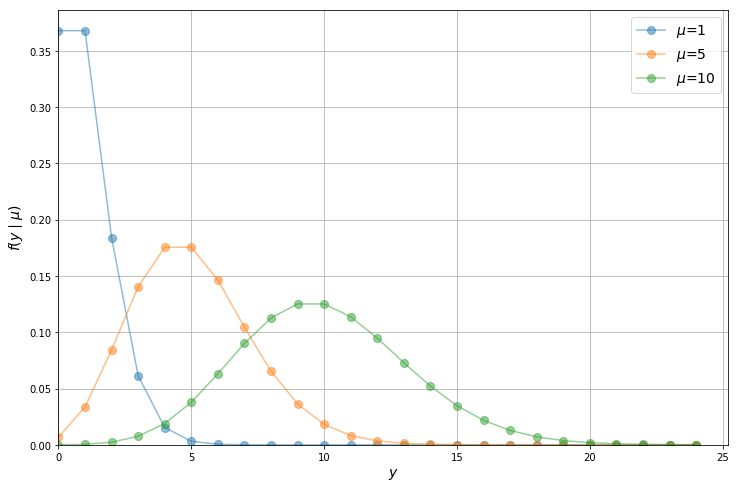

In [1]:
from numpy import exp
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

poisson_pmf = lambda y, μ: μ**y / factorial(y) * exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(12, 8))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

In [2]:
import pandas as pd
pd.options.display.max_columns = 10

# Load in data and view
df = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/mle/fp.dta')
df.head()

,country,ccode,year,cyear,numbil,...,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,...,39.799999,4.988405,20.0,1.61,NaN


/home/sim/app/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


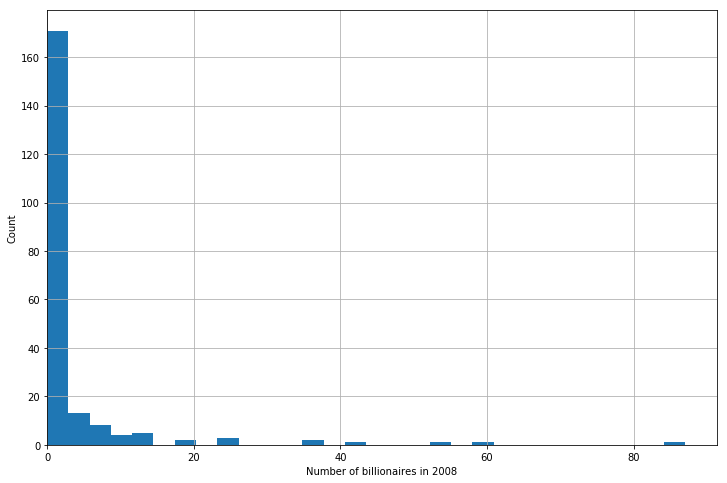

In [3]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(12, 8))
plt.hist(numbil0_2008, bins=30)
plt.xlim(xmin=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

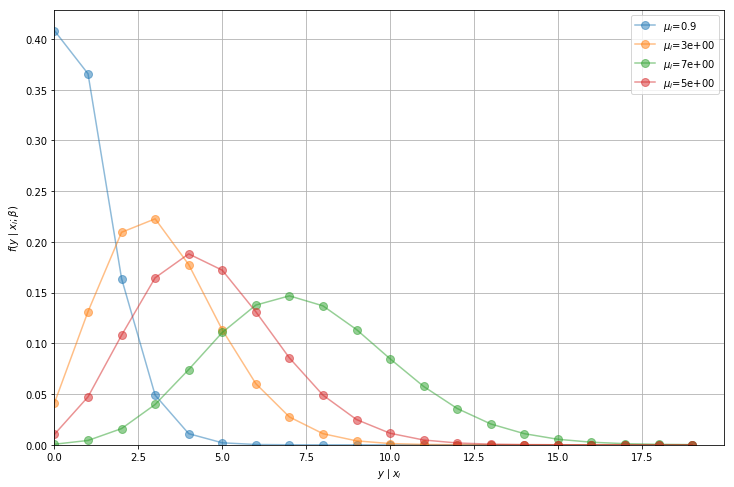

In [4]:
import numpy as np

y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22]).T

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(12, 8))

for X in datasets:
    μ = exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

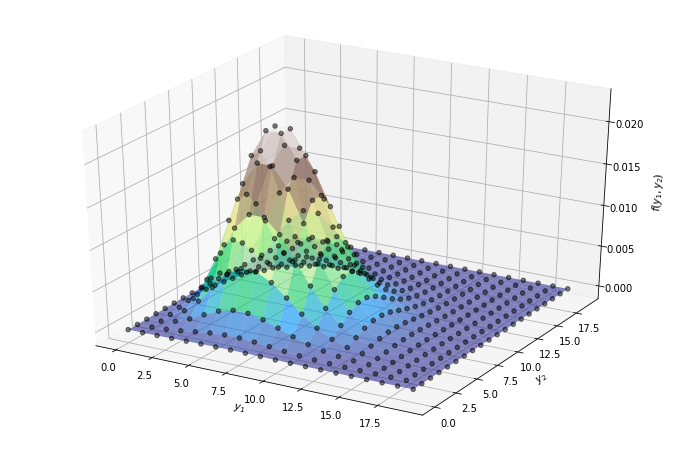

In [5]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=7, y_n=20)

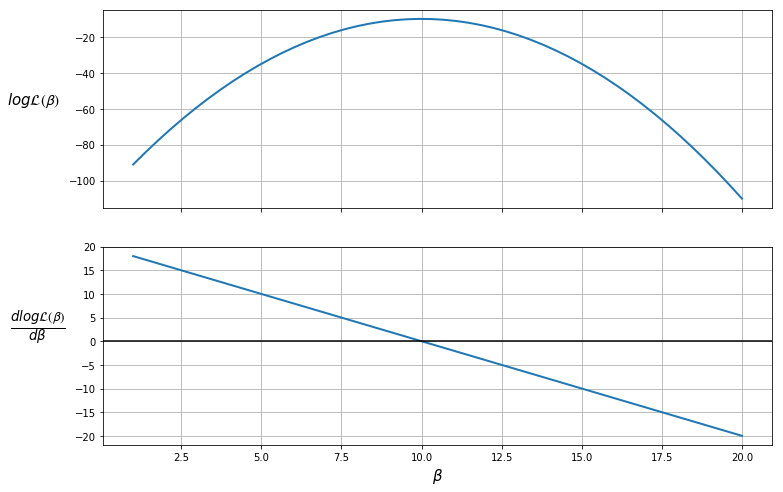

In [6]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

In [31]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X, self.y, self.β = X, y, β
        self.n, self.k = X.shape

    def μ_bk(self):
        return np.exp(self.X @ self.β.T)
    
    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        μ = self.μ()
        return ((self.y - μ) @ self.X).reshape(self.k, 1)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(μ * X.T @ X)

In [32]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G).T
        error = β_new - model.β
        model.β = β_new.flatten()

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β)]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β}')

    return model.β

In [33]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
β_hat = [-6.07848205  0.93340226  0.84329625]


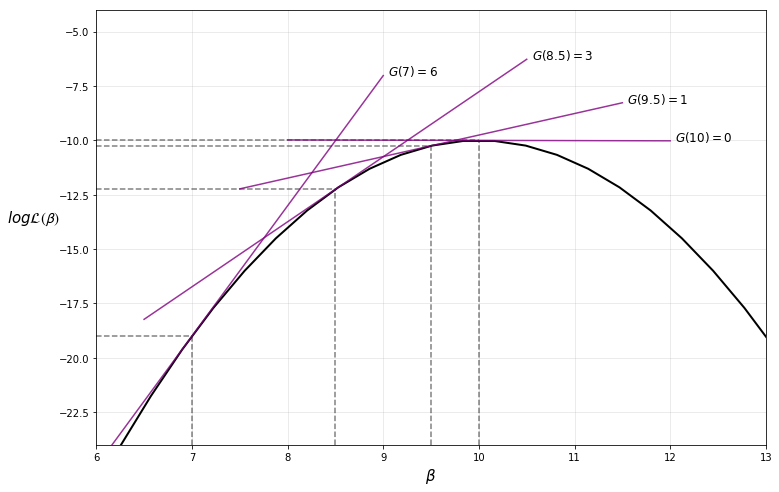

In [34]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(β, a=0.01):
    y1 = logL(β)
    y2 = logL(β+a)
    x = np.array([[β, 1], [β+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]), rcond=None)[0]
    return m, c

β = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(β, logL(β), lw=2, c='black')

for β in [7, 8.5, 9.5, 10]:
    β_line = np.linspace(β-2, β+2)
    m, c = find_tangent(β)
    y = m * β_line + c
    ax.plot(β_line, y, '-', c='purple', alpha=0.8)
    ax.text(β+2.05, y[-1], f'$G({β}) = {abs(m):.0f}$', fontsize=12)
    ax.vlines(β, -24, logL(β), linestyles='--', alpha=0.5)
    ax.hlines(logL(β), 6, β, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=25,
               fontsize=15)
ax.grid(alpha=0.3)
plt.show()

In [35]:
from statsmodels.api import Poisson
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 Mar 2019   Pseudo R-squ.:                  0.2546
Time:                        15:48:07   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
                                        LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

In [36]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

In [28]:
import statsmodels.api as sm

# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Mon, 25 Mar 2019   Pseudo R-squ.:                  0.8574
Time:                        14:55:12   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

In [29]:
from statsmodels.iolib.summary2 import summary_col

regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0', maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw                                 0.203

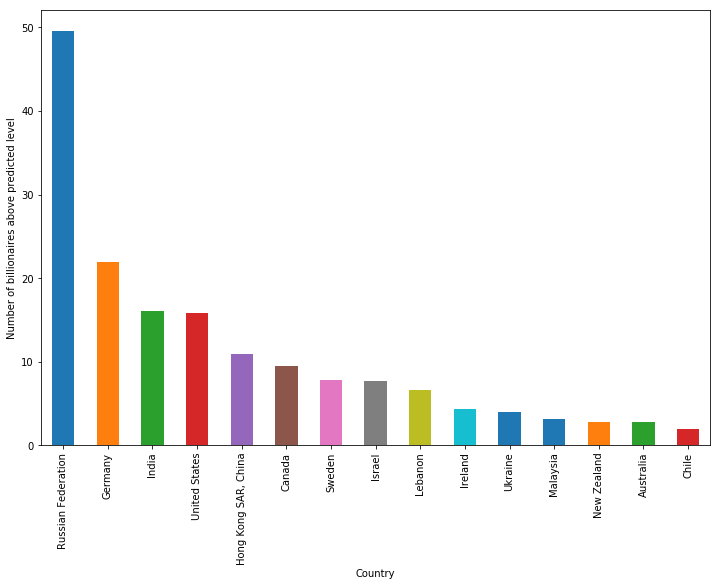

In [30]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar', figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

# Exercise 1

Suppose we wanted to estimate the probability of an event yi occurring, given some observations

We could use a **probit** regression model, where the pmf of yi is

f(yi;β)=μyii(1−μi)1−yi,yi=0,1

whereμi=Φ(x′iβ)


Φ represents the cumulative normal distribution and constrains the predicted yi to be between 0 and 1 (as required for a probability)

β is a vector of coefficients

Following the example in the lecture, **write a class to represent the Probit model**

To begin, find the log-likelihood function and derive the gradient and Hessian

The scipy module stats.norm contains the functions needed to compute the cmf and pmf of the normal distribution

In [1]:
from scipy.stats import norm

class ProbitRegression:

    def __init__(self, y, X, β):
        self.X, self.y, self.β = X, y, β
        self.n, self.k = X.shape

    def μ(self):
        return norm.cdf(self.X @ self.β.T)

    def ϕ(self):
        return norm.pdf(self.X @ self.β.T)

    def logL(self):
        μ = self.μ()
        return np.sum(y * np.log(μ) + (1 - y) * np.log(1 - μ))

    def G(self):
        μ = self.μ()
        ϕ = self.ϕ()
        return np.sum((X.T * y * ϕ / μ - X.T * (1 - y) * ϕ / (1 - μ)), axis=1)

    def H(self):
        X = self.X
        β = self.β
        μ = self.μ()
        ϕ = self.ϕ()
        a = (ϕ + (X @ β.T) * μ) / μ**2
        b = (ϕ - (X @ β.T) * (1 - μ)) / (1 - μ)**2
        return -(ϕ * (y * a + (1 - y) * b) * X.T) @ X

# Ex 2

Use the following dataset and initial values of β to estimate the MLE with the Newton-Raphson algorithm developed earlier in the lecture

X=⎡⎣⎢⎢⎢⎢⎢⎢111112145341365⎤⎦⎥⎥⎥⎥⎥⎥y=⎡⎣⎢⎢⎢⎢⎢⎢10110⎤⎦⎥⎥⎥⎥⎥⎥β(0)=⎡⎣⎢0.10.10.1⎤⎦⎥

Verify your results with statsmodels - you can import the Probit function with the following import statement

In [15]:
import numpy as np

X = np.array([(1,2,4),
             (1,1,1),
             (1,4,3),
             (1,5,6),
             (1,3,5)])

y = np.array([1,0,1,1,0])

init_beta = np.array([.1,.1,.1])

In [11]:
from statsmodels.discrete.discrete_model import Probit
from scipy import stats

stats_probit = Probit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.473746
         Iterations 6


In [13]:
print(stats_probit.summary())

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                         Probit   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Tue, 26 Mar 2019   Pseudo R-squ.:                  0.2961
Time:                        09:20:28   Log-Likelihood:                -2.3687
converged:                       True   LL-Null:                       -3.3651
                                        LLR p-value:                    0.3692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5463      1.866     -0.829      0.407      -5.204       2.111
x1             0.7778      0.788      0.986      0.324      -0.768       2.323
x2            -0.0971      0.590     -0.165      0.8

In [18]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G).T
        error = β_new - model.β
        model.β = β_new.flatten()

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β)]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β}')

    return model.β


In [19]:

obj = ProbitRegression(y, X, init_beta)
beta_hat = newton_raphson(obj)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -2.3796884      ['-1.34', '0.775', '-0.157']
1            -2.3687526      ['-1.53', '0.775', '-0.0981']
2            -2.3687294      ['-1.55', '0.778', '-0.0971']
3            -2.3687294      ['-1.55', '0.778', '-0.0971']
Number of iterations: 4
β_hat = [-1.54625858  0.77778952 -0.09709757]
